# Homework 2 - Exploring the NASA GES-DISC Dataset
**Author - Abde Manaaf Ghadiali (G29583342)**

Link prediction is a fundamental task in network science and machine learning, where the goal is to infer missing connections or predict future interactions in a graph. It is widely applied in various fields, such as social network analysis, recommender systems, and knowledge graph completion.

In this project, we focus on link prediction using the **NASA GES-DISC Knowledge Graph**. This dataset, provided by NASA's Goddard Earth Sciences Data and Information Services Center (GES-DISC), represents a knowledge graph of collections including datasets, data centers, projects, platforms, instruments, science keywords, and publications. Relationships between these entities are also captured, creating a comprehensive knowledge graph designed specifically for link prediction tasks.

The knowledge graph includes:
- **Nodes**: Different types of entities, such as datasets, data centers, projects, platforms, instruments, science keywords, and publications.
- **Edges**: Relationships between these nodes, representing known associations, collaborations, or dependencies.

The purpose of this link prediction task is to predict missing or future links within the GES-DISC knowledge graph. Successful link prediction can help in identifying potential collaborations, uncovering hidden connections, and enhancing data discovery across NASA's earth science resources.

The dataset includes:
- **Training edges**: Known links used to train machine learning models.
- **Validation and test edges**: Separate sets of links used for evaluating model performance.

This project will explore various machine learning techniques for link prediction, leveraging the unique structure and metadata of the GES-DISC knowledge graph to improve predictive accuracy.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#### Downloading Data Files


The following code snippet downloads multiple files from specified URLs and saves them to a folder named `../data/` using PyTorch Geometric's `download_url` function.

In [2]:
from torch_geometric.data import download_url

# Define the list of URLs for each dataset file to be downloaded
data_paths = [
    "https://zenodo.org/records/11492533/files/croissant_metadata.json?download=1",
    "https://zenodo.org/records/11492533/files/nodes.csv?download=1",
    "https://zenodo.org/records/11492533/files/README.md?download=1",
    "https://zenodo.org/records/11492533/files/test_links.csv?download=1",
    "https://zenodo.org/records/11492533/files/train_edges.csv?download=1",
    "https://zenodo.org/records/11492533/files/val_links.csv?download=1"
]

# Downloads a list of files from specified URLs and saves them to the destination folder
for path in data_paths:
    download_url(path, log=True, folder="../data/")

Using existing file croissant_metadata.json
Using existing file nodes.csv
Using existing file README.md
Using existing file test_links.csv
Using existing file train_edges.csv
Using existing file val_links.csv


# Reading, Preprocessing and Creating Graph from Data

Firstly we read and process the nodes and edges data for the link prediction task.

1. **Data Loading**: `nodes_data` includes metadata about nodes (e.g., datasets, publications), while `edges_data` represents connections between these nodes.
2. **Label Cleaning**: The `label` column in `nodes_data` is processed to remove the first two and last two characters, likely for cleaning special characters or extra markers.

In [3]:
import pandas as pd

# Load nodes and edges data from CSV files
nodes_data = pd.read_csv('../data/nodes.csv', encoding='UTF-8')
edges_data = pd.read_csv('../data/train_edges.csv')

# Clean the 'label' column by removing the first and last two characters from each label
nodes_data['label'] = nodes_data['label'].str.slice(2, -2)

# Define features to drop for each node type to retain only relevant information
drop_features = {
    "Dataset": ["globalId", "daac", "doi", "shortName", "abstract"], "DataCenter": ["globalId", "url", "shortName"], "Project": ["globalId", "shortName"],
    "Platform": ["globalId", "shortName", "Type"], "Instrument": ["globalId", "shortName"], "Publication": ["globalId", "DOI", "Year"], "ScienceKeyword": ["globalId"]
}

In [4]:
nodes_data

,id,label,properties
0,0,Dataset,{'abstract': 'The Atmospheric Infrared Sounder...
1,1,Dataset,{'abstract': 'Version 07 is the current versio...
2,2,Dataset,{'abstract': 'The Solar Backscattered Ultravio...
3,3,Dataset,{'abstract': 'The data presented in this level...
4,4,Dataset,{'abstract': 'The TROPESS CrIS-SNPP L2 for Sao...
...,...,...,...
5758,25019,ScienceKeyword,"{'name': 'WATER ION CONCENTRATIONS', 'globalId..."
5759,25020,ScienceKeyword,"{'name': 'WATER TRACE ELEMENTS', 'globalId': '..."
5760,25021,ScienceKeyword,"{'name': 'pH', 'globalId': 'd2cbb2ca-aaa2-54f1..."
5761,25022,ScienceKeyword,"{'name': 'WATER QUALITY INDEXES', 'globalId': ..."


In [5]:
edges_data

,source,target,relationship_type
0,1152,1354,OF_PROJECT
1,1317,1164,HAS_DATASET
2,1317,768,HAS_DATASET
3,1271,23795,HAS_SCIENCEKEYWORD
4,820,23837,HAS_SCIENCEKEYWORD
...,...,...,...
13815,21903,495,USES_DATASET
13816,1274,23723,HAS_SCIENCEKEYWORD
13817,12187,1208,USES_DATASET
13818,302,1373,HAS_PLATFORM


In [6]:
# Labels Frequency Summary
nodes_data.groupby('label').size().reset_index(name='# of Nodes per Label').rename(columns={'label': 'Labels'})

,Labels,# of Nodes per Label
0,DataCenter,1
1,Dataset,1300
2,Instrument,83
3,Platform,142
4,Project,44
5,Publication,2584
6,ScienceKeyword,1609


In [7]:
edges_data_summary = edges_data.copy()

edges_data_summary['source'] = edges_data_summary['source'].map(lambda x: nodes_data[nodes_data['id'] == x]['label'].values[0])
edges_data_summary['target'] = edges_data_summary['target'].map(lambda x: nodes_data[nodes_data['id'] == x]['label'].values[0])

# Edges Frequency Summary
edges_data_summary.groupby(['source', 'relationship_type', 'target']).size().reset_index(name='# of Edge Types').rename(columns={
    'source': 'Source', 'relationship_type': 'Relationship Type', 'target': 'Target'})

,Source,Relationship Type,Target,# of Edge Types
0,DataCenter,HAS_DATASET,Dataset,1300
1,Dataset,HAS_PLATFORM,Platform,1519
2,Dataset,HAS_SCIENCEKEYWORD,ScienceKeyword,4015
3,Dataset,OF_PROJECT,Project,1325
4,Platform,HAS_INSTRUMENT,Instrument,215
5,Publication,USES_DATASET,Dataset,3623
6,ScienceKeyword,SUBCATEGORY_OF,ScienceKeyword,1823


Now we processes node data by transforming properties, dropping irrelevant features, and restructuring the data for each node type. 

1. **Node Data Dictionary Creation**:
   - `node_data_dict`: An empty dictionary to store subsets of `nodes_data` by each unique `label` (e.g., "Dataset," "Publication").
   - For each unique label in `nodes_data`, a filtered DataFrame for that label is created and stored in `node_data_dict`.

2. **Processing Each Label’s Dataset**:
   - For each `label` in `node_data_dict`, the `properties` column is parsed into separate columns using `ast.literal_eval`, which converts each entry in `properties` to a dictionary.
   - The `properties` data is combined with the rest of the `dataset`, and irrelevant columns (as defined in `drop_features`) are removed.

3. **Updating `node_data_dict`**:
   - The dictionary is reset to store lists of `[id, description]` for each label, making the data format more accessible for further processing.

In [8]:
import ast
from functools import reduce
from tqdm import tqdm

# Initialize an empty dictionary to store subsets of nodes data based on their labels
node_data_dict = {}

# Split `nodes_data` into separate DataFrames for each unique label type
for label in tqdm(nodes_data['label'].unique().tolist(), desc='Separating Labels Dataframes: '):
    node_data_dict[label] = nodes_data[nodes_data['label'] == label].reset_index(drop=True)

# Process each dataset by extracting properties and renaming columns
for label, dataset in tqdm(node_data_dict.items(), desc='Processing Relevant Features: '):

    # Convert the 'properties' column strings to dictionaries
    property_data = list(map(ast.literal_eval, dataset['properties'].values.tolist()))

    # Merge `properties` into the dataset and drop unnecessary columns
    feature_data = pd.concat([dataset, pd.DataFrame(property_data)], axis=1).drop(columns=['properties'] + drop_features[label])

    # Identify the main feature column and rename it to 'description'
    feature_column = feature_data.drop(columns=['id', 'label']).columns.to_list()[0]
    node_data_dict[label] = feature_data.rename(columns={feature_column: 'description'})

# Concatenate all processed node data into a single DataFrame
nodes_data = reduce(lambda x, y: pd.concat([x, y], ignore_index=True), node_data_dict.values())

# Reset `node_data_dict` to store simplified data with only 'id' and 'description'
node_data_dict = {}

# Store id and description for each label in `node_data_dict`
for label in nodes_data['label'].unique():
    node_data_dict[label] = nodes_data[nodes_data['label'] == label][['id', 'description']].values.tolist()

Processing Relevant Features: 100%|██████████| 7/7 [00:00<00:00, 70.30it/s]


In [9]:
node_data_dict.keys()

dict_keys(['Dataset', 'DataCenter', 'Project', 'Platform', 'Instrument', 'Publication', 'ScienceKeyword'])

Next, we process edges data to categorize and store relationships between different types of nodes.

1. **Iterating Through Edges Data**:
   - For each row in `edges_data`, the code retrieves the `source_type` and `destination_type` by matching node IDs in `nodes_data`.
   - The relationship type (stored in the third column of `edges_data`) is also retrieved.

2. **Dictionary Key Creation**:
   - A tuple `(source_type, relationship, destination_type)` is created as a key for `edge_dict`.
   - If the key does not already exist in `edge_dict`, it is initialized with a list containing the current edge (as a tuple of source and destination node IDs).
   - If the key exists, the edge is appended to the existing list.

In [10]:
# Initialize an empty dictionary to store edges by source, relationship, and destination types
edge_dict = {}

# Process each edge in `edges_data`
for row_idx in tqdm(range(edges_data.shape[0]), desc='Processing Edges: '):

    # Identify the source and destination node types using `nodes_data`
    source_type = nodes_data[nodes_data['id'] == edges_data.iloc[row_idx, 0]]['label'].values[0]
    destination_type = nodes_data[nodes_data['id'] == edges_data.iloc[row_idx, 1]]['label'].values[0]
    relationship = edges_data.iloc[row_idx, 2]

    # Create a unique dictionary key based on source type, relationship, and destination type
    dict_key = (source_type, relationship, destination_type)

    # Append the edge to `edge_dict`, initializing a new list if the key is not present
    if dict_key not in edge_dict:
        edge_dict[dict_key] = [(int(edges_data.iloc[row_idx, 0]), int(edges_data.iloc[row_idx, 1]))]
    else:
        edge_dict[dict_key].append((int(edges_data.iloc[row_idx, 0]), int(edges_data.iloc[row_idx, 1])))

edge_dict.keys()

Processing Edges: 100%|██████████| 13820/13820 [00:03<00:00, 3832.19it/s]


dict_keys([('Dataset', 'OF_PROJECT', 'Project'), ('DataCenter', 'HAS_DATASET', 'Dataset'), ('Dataset', 'HAS_SCIENCEKEYWORD', 'ScienceKeyword'), ('Publication', 'USES_DATASET', 'Dataset'), ('Dataset', 'HAS_PLATFORM', 'Platform'), ('ScienceKeyword', 'SUBCATEGORY_OF', 'ScienceKeyword'), ('Platform', 'HAS_INSTRUMENT', 'Instrument')])

#### Directed Graph Creation

Finally, we construct a directed graph with nodes and edges using embeddings for node features. It leverages the SentenceTransformer model to generate embeddings and NetworkX to build the graph.

1. **Graph and Embedding Model Initialization**:
   - An empty directed graph `G` is created using `nx.DiGraph()`.
   - `embedding_model` is initialized using a pre-trained SentenceTransformer model (`all-MiniLM-L6-v2`), selected for generating sentence embeddings.

2. **Node Embedding Generation and Addition**:
   - For each label type and corresponding node information in `node_data_dict`:
     - If the `node_feature` is missing (`np.nan`), the embedding for the `data_label` itself is generated.
     - Otherwise, an embedding for `node_feature` is generated.
     - Each node, with its ID, label, and embedding, is added to the graph `G`.

3. **Edge Addition**:
   - For each unique edge type in `edge_dict`, edges are added to `G` with a relationship attribute, connecting source and target nodes.

In [11]:
import torch
import networkx as nx
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Set up device for model processing (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize an empty directed graph and a SentenceTransformer model for embeddings
G = nx.DiGraph()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Generate embeddings and add nodes to the graph
for data_label, nodes_info in node_data_dict.items():
    for node_id, node_feature in tqdm(nodes_info, desc=f'Generating Embeddings for {data_label}: '):

        # Initialize variable for storing embeddings
        embeddings = None

        # Generate embedding based on feature presence
        if node_feature is np.nan:

            # Use data label as embedding if feature is missing
            embeddings = embedding_model.encode(data_label, convert_to_tensor=True, show_progress_bar=False, device=device)
        else:

            # Use node feature as embedding
            embeddings = embedding_model.encode(node_feature, convert_to_tensor=True, show_progress_bar=False, device=device)

        # Add node to the graph with label and feature embeddings
        G.add_nodes_from([(node_id, {"node_label": data_label, "feature_embeddings": embeddings})])

print()

# Add edges to the graph with relationship attributes
for edge_relatipnship, edge_list in edge_dict.items():
    for source_node, target_node in tqdm(edge_list, desc=f'Adding Edges to Graph {edge_relatipnship}: '):

        # Add edge with relationship attribute
        G.add_edges_from([(source_node, target_node, {"relationship": edge_relatipnship})])

Generating Embeddings for ScienceKeyword: 100%|██████████| 1609/1609 [00:06<00:00, 253.95it/s]


Adding Edges to Graph ('Dataset', 'OF_PROJECT', 'Project'): 100%|██████████| 1325/1325 [00:00<00:00, 1191563.64it/s]
Adding Edges to Graph ('DataCenter', 'HAS_DATASET', 'Dataset'): 100%|██████████| 1300/1300 [00:00<00:00, 595261.48it/s]
Adding Edges to Graph ('Dataset', 'HAS_SCIENCEKEYWORD', 'ScienceKeyword'): 100%|██████████| 4015/4015 [00:00<00:00, 935510.84it/s]
Adding Edges to Graph ('Publication', 'USES_DATASET', 'Dataset'): 100%|██████████| 3623/3623 [00:00<00:00, 1340741.43it/s]
Adding Edges to Graph ('Dataset', 'HAS_PLATFORM', 'Platform'): 100%|██████████| 1519/1519 [00:00<?, ?it/s]
Adding Edges to Graph ('ScienceKeyword', 'SUBCATEGORY_OF', 'ScienceKeyword'): 100%|██████████| 1823/1823 [00:00<00:00, 317112.48it/s]
Adding Edges to Graph ('Platform', 'HAS_INSTRUMENT', 'Instrument'): 100%|██████████| 215/215 [00:00<00:00, 215220.85it/s]


In [12]:
print("\nGraph Information:")
print(f"\tNumber of Nodes: {len(G.nodes)}")
print(f"\tNumber of Edges: {len(G.edges)}")
print(f"\tIs Directed: {G.is_directed()}")


Graph Information:
	Number of Nodes: 5763
	Number of Edges: 13820
	Is Directed: True


Here we visualizes the NASA GES-DISC graph with color-coded nodes based on node type.

1. **Node Positioning**:
   - `nx.spring_layout(G)` is used to compute positions for nodes based on a spring layout, which positions nodes to minimize edge overlap and improve readability.

2. **Graph Drawing**:
   - `nx.draw_networkx` is used to draw `G` with specified node positions and colors, applying `base_options`.
   - `plt.tight_layout()` is called to reduce extra padding around the plot.

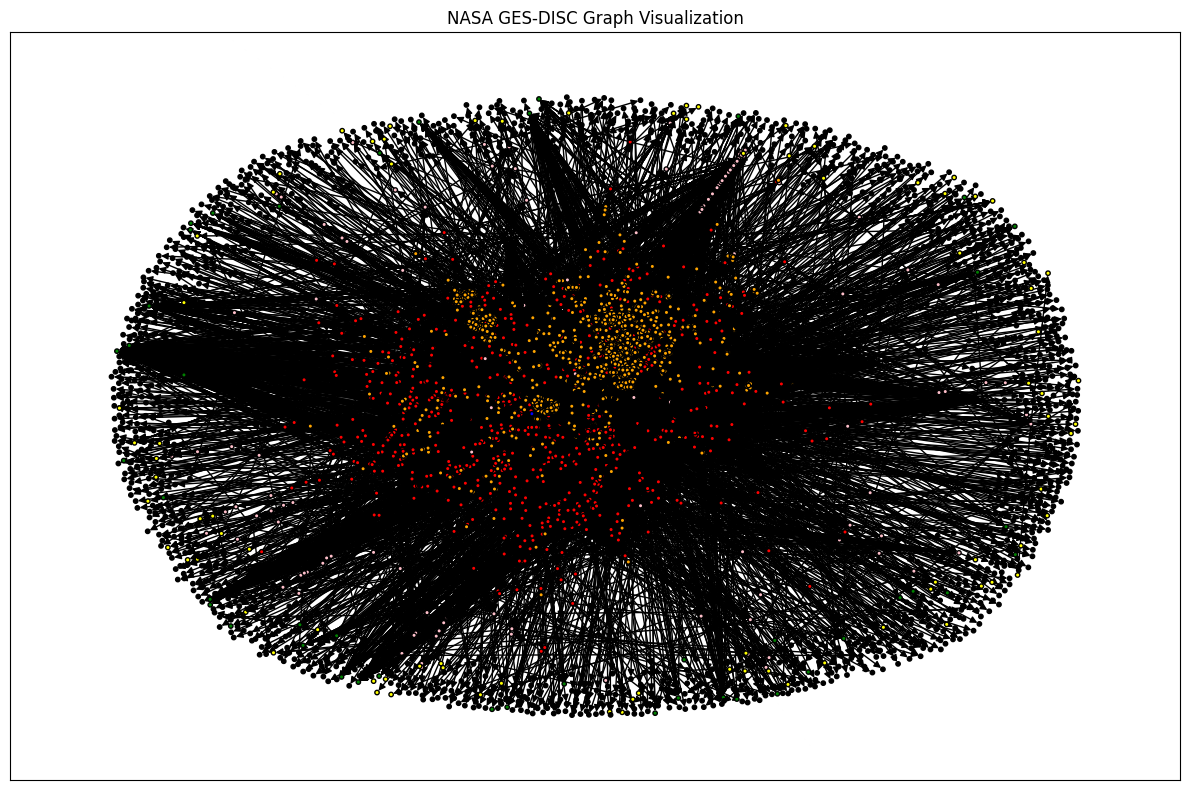

In [13]:
import matplotlib.pyplot as plt

# Define color map for each node type
color_map = {
    "Dataset": 'red', "DataCenter": 'blue', "Project": 'green', "Platform": 'pink',
    "Instrument": 'yellow', "Publication": 'orange', "ScienceKeyword": 'black'}

# Set base drawing options for the graph
base_options = {"with_labels": False, "edgecolors": "black", "node_size": 10}

# Set up the figure and title
plt.figure(figsize=(12, 8))
plt.title("NASA GES-DISC Graph Visualization")

# Calculate node positions using a spring layout
pos = nx.spring_layout(G)

# Assign colors to nodes based on their labels using the color map
node_colors = [color_map[node_attributes["node_label"]] for _, node_attributes in G.nodes(data=True)]

# Draw the graph with specified options
nx.draw_networkx(G, pos=pos, node_color=node_colors, **base_options)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Method 1 - Non-Embedding Based Approachs

## Approach 1.1 - Jaccard Coefficients for One-Hop Neighbours

In this approach, we use Jaccard coefficients to measure the similarity between nodes based on their one-hop neighbors. The Jaccard coefficient is defined as the size of the intersection divided by the size of the union of the neighbors of two nodes. By calculating the Jaccard coefficient for each pair of nodes, we can estimate the likelihood of a link existing between them. This method captures the structural similarity of nodes in the network, as nodes with more shared neighbors are likely to be connected. It is a straightforward, unsupervised metric for link prediction that leverages neighborhood overlap.


First, we load validation and test edge data from CSV files, then prepare the data for link prediction evaluation by converting it to sets of edges.
   - `validation_data_edges`: A set of tuples, each representing an edge in the validation dataset. This set format makes it easy to perform quick membership tests and comparisons during evaluation.
   - `test_data_edges`: A set of tuples representing edges in the test dataset.

In [14]:
# Load validation and test edges from CSV files
validation_data = pd.read_csv("../data/val_links.csv")
test_data = pd.read_csv("../data/test_links.csv")

# Convert validation and test data into sets of edges (tuples) for faster lookup
validation_data_edges = set(zip(validation_data['source'], validation_data['target']))
test_data_edges = set(zip(test_data['source'], test_data['target']))

Next, we separate nodes in the graph `G` into two lists: one for nodes labeled as "Dataset" and another for nodes labeled as "ScienceKeyword".

In [15]:
# Initialize lists to store nodes based on their labels
dataset_nodes = []
science_keywords_nodes = []

# Iterate over all nodes in the graph
for node_id in list(G.nodes):

    # Check node label and add the node ID to the appropriate list
    if G.nodes[node_id]["node_label"] == "Dataset":
        dataset_nodes.append(node_id)
    elif G.nodes[node_id]["node_label"] == "ScienceKeyword":
        science_keywords_nodes.append(node_id)

Now, we calculates the Jaccard coefficient between pairs of nodes labeled "Dataset" and "ScienceKeyword" in the graph `G`, where an edge does not already exist. The Jaccard coefficient is a measure of similarity based on shared neighbors.

**Jaccard Coefficient Calculation**:
   - For each `dataset_node` and `science_keywords_node` pair:
     - **Edge Check**: The coefficient is only calculated if there is no existing edge between the nodes.
     - **Common and All Neighbors**:
       - `common_neighbours`: Intersection of neighbors between `dataset_node` and `science_keywords_node`.
       - `all_neighbours`: Union of neighbors between the two nodes.
     - **Coefficient Calculation**: The Jaccard coefficient is computed as the ratio of the size of `common_neighbours` to `all_neighbours`. If there are no neighbors, the coefficient is set to 0.
     - Non-zero coefficients are stored in `jaccard_coef_list`.

In [16]:
# Initialize list to store Jaccard coefficients for potential edges
jaccard_coef_list = []

# Calculate Jaccard coefficient for each (Dataset, ScienceKeyword) pair without an existing edge
for dataset_node in tqdm(dataset_nodes, desc='Jaccard Coefficient for Nodes: '):
    for science_keywords_node in science_keywords_nodes:

        # Check if an edge already exists
        if not G.has_edge(dataset_node, science_keywords_node):

            # Find common and all neighbors for Jaccard calculation
            common_neighbours = set(G.neighbors(dataset_node)) & set(G.neighbors(science_keywords_node))
            all_neighbours = set(G.neighbors(dataset_node)) | set(G.neighbors(science_keywords_node))

            # Calculate Jaccard coefficient, handle division by zero
            coef = len(common_neighbours) / len(all_neighbours) if len(all_neighbours) != 0 else 0

            # Store non-zero Jaccard coefficient with node pair
            if not (coef == 0):
                jaccard_coef_list.append((dataset_node, science_keywords_node, coef))

Jaccard Coefficient for Nodes: 100%|██████████| 1300/1300 [00:02<00:00, 473.68it/s]


#### Validation Data Scores

Finally we evaluate the link prediction performance using the Jaccard coefficient on the validation dataset by calculating accuracy, precision, recall, and F1-score.

In [17]:
# Filter validation edges with Jaccard coefficients that match the validation dataset edges
validation_jaccard_scores = [(u, v, score) for u, v, score in jaccard_coef_list if (u, v) in validation_data_edges]
val_predicted_edges = {(u, v) for u, v, _ in validation_jaccard_scores}

# Calculate true positives, false positives, and false negatives
true_positives = len(val_predicted_edges & validation_data_edges)
false_positives = len(val_predicted_edges - validation_data_edges)
false_negatives = len(validation_data_edges - val_predicted_edges)

# Calculate precision, recall, F1-score, and accuracy
val_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
val_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall) if (val_precision + val_recall) > 0 else 0
val_accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0

# Print evaluation metrics
print(f"Validation Accuracy: {val_accuracy:.3f}")
print(f"Validation Precision: {val_precision:.3f}")
print(f"Validation Recall: {val_recall:.3f}")
print(f"Validation F1-score: {val_f1_score:.3f}")

Validation Accuracy: 0.272
Validation Precision: 1.000
Validation Recall: 0.272
Validation F1-score: 0.428


#### Test Data Scores

In [18]:
test_jaccard_scores = [(u, v, score) for u, v, score in jaccard_coef_list if (u, v) in test_data_edges]
test_predicted_edges = {(u, v) for u, v, _ in test_jaccard_scores}

true_positives = len(test_predicted_edges & test_data_edges)
false_positives = len(test_predicted_edges - test_data_edges)
false_negatives = len(test_data_edges - test_predicted_edges)

test_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
test_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0
test_accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test F1-score: {test_f1_score:.3f}")

Test Accuracy: 0.258
Test Precision: 1.000
Test Recall: 0.258
Test F1-score: 0.410


## Approach 1.2 - Jaccard Coefficients for 'n'-Hop Neighbours

In this approach, we extend the Jaccard coefficient calculation to 'n'-hop neighbors, where 'n' represents the depth of neighbors considered for each node. Unlike the one-hop Jaccard coefficient, which only considers direct neighbors, this method includes neighbors within 'n' hops, capturing a broader context of the network's structure. By calculating the intersection and union of 'n'-hop neighbors, we assess the similarity of nodes at a deeper level. This approach can be particularly useful in networks where indirect relationships are informative, enhancing link prediction by considering multi-hop connections.


Next, we calculate the Jaccard coefficient for pairs of "Dataset" and "ScienceKeyword" nodes, considering neighbors up to a specified hop distance (`nhops`). This extended neighborhood-based Jaccard coefficient can help identify more distant relationships between nodes in the graph `G`.

1. **Initialization**:
   - `jaccard_coef_list`: Stores tuples of `(dataset_node, science_keywords_node, coef)`, where `coef` is the Jaccard coefficient for each node pair.
   - `nhops`: Defines the neighborhood radius (in hops) to consider when calculating neighbors.

2. **Node Pair Iteration and Neighbor Calculation**:
   - For each `dataset_node` and `science_keywords_node` pair:
     - **Edge Check**: Only calculate the coefficient if there is no existing edge between the two nodes.
     - **N-hop Neighborhood Calculation**:
       - `nhop_dataset_neighbours` and `nhop_science_keyword_neighbours` are sets of neighbors within `nhops` distance from `dataset_node` and `science_keywords_node`, respectively.
       - The nodes themselves are removed from their own neighborhood sets to prevent self-influence.
     - **Jaccard Coefficient Calculation**:
       - `common_neighbours`: Intersection of the two neighborhood sets.
       - `all_neighbours`: Union of the two neighborhood sets.
       - The Jaccard coefficient (`coef`) is computed as the ratio of `common_neighbours` to `all_neighbours`, with a 0 coefficient for cases with no neighbors.
       - Non-zero coefficients are stored in `jaccard_coef_list`.

In [19]:
# Initialize list to store Jaccard coefficients for potential edges
jaccard_coef_list = []

# Define the number of hops for neighborhood consideration
nhops = 4

# Calculate Jaccard coefficient for each (Dataset, ScienceKeyword) pair without an existing edge
for dataset_node in tqdm(dataset_nodes):
    for science_keywords_node in science_keywords_nodes:

        # Check if an edge already exists
        if not G.has_edge(dataset_node, science_keywords_node):

            # Get neighbors within 'nhops' distance for both nodes
            nhop_dataset_neighbours = set(nx.single_source_shortest_path_length(G, dataset_node, cutoff=nhops).keys())
            nhop_science_keyword_neighbours = set(nx.single_source_shortest_path_length(G, science_keywords_node, cutoff=nhops).keys())

            # Remove the nodes themselves from their respective neighborhoods
            nhop_dataset_neighbours.discard(dataset_node)
            nhop_science_keyword_neighbours.discard(science_keywords_node)

            # Calculate common and all neighbors for Jaccard calculation
            common_neighbours = nhop_dataset_neighbours & nhop_science_keyword_neighbours
            all_neighbours = nhop_science_keyword_neighbours | nhop_science_keyword_neighbours

            # Calculate Jaccard coefficient, handling division by zero
            coef = len(common_neighbours) / len(all_neighbours) if len(all_neighbours) != 0 else 0

            # Store non-zero Jaccard coefficient with node pair
            if not (coef == 0):
                jaccard_coef_list.append((dataset_node, science_keywords_node, coef))

100%|██████████| 1300/1300 [01:32<00:00, 14.03it/s]


#### Validation Scores

In [20]:
validation_jaccard_scores = [(u, v, score) for u, v, score in jaccard_coef_list if (u, v) in validation_data_edges]
val_predicted_edges = {(u, v) for u, v, _ in validation_jaccard_scores}

true_positives = len(val_predicted_edges & validation_data_edges)
false_positives = len(val_predicted_edges - validation_data_edges)
false_negatives = len(validation_data_edges - val_predicted_edges)

val_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
val_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall) if (val_precision + val_recall) > 0 else 0
val_accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0

print(f"Validation Accuracy: {val_accuracy:.3f}")
print(f"Validation Precision: {val_precision:.3f}")
print(f"Validation Recall: {val_recall:.3f}")
print(f"Validation F1-score: {val_f1_score:.3f}")

Validation Accuracy: 0.833
Validation Precision: 1.000
Validation Recall: 0.833
Validation F1-score: 0.909


#### Test Data Scores

In [21]:
test_jaccard_scores = [(u, v, score) for u, v, score in jaccard_coef_list if (u, v) in test_data_edges]
test_predicted_edges = {(u, v) for u, v, _ in test_jaccard_scores}

true_positives = len(test_predicted_edges & test_data_edges)
false_positives = len(test_predicted_edges - test_data_edges)
false_negatives = len(test_data_edges - test_predicted_edges)

test_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
test_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0
test_accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test F1-score: {test_f1_score:.3f}")

Test Accuracy: 0.848
Test Precision: 1.000
Test Recall: 0.848
Test F1-score: 0.918


# Method 2 - Embedding Based Approaches

## Approach 2.1 - Graph Node Embeddings Using Node2Vec and Classification Model

In this approach, we generate embeddings for nodes using the Node2Vec algorithm, which captures the structural and community information of nodes through biased random walks. Node2Vec creates node representations by exploring both homophily (nodes with similar neighbors) and structural equivalence (nodes with similar roles) through a flexible balance between breadth-first (BFS) and depth-first (DFS) search strategies. Once the embeddings are generated, we train a classification model to predict links by using the embeddings of node pairs as features. This approach leverages both graph structure and node relationships to enhance link prediction accuracy, making it well-suited for complex networks with diverse connection patterns.


Now, uses the Node2Vec algorithm to learn embeddings for the nodes in the graph `G`. Node2Vec is a method that captures structural patterns in a graph by performing random walks on the nodes and then applying the Word2Vec algorithm to learn node embeddings based on these walks.

1. **Node2Vec Initialization**:
   - `Node2Vec(G, walk_length=40, num_walks=100, workers=1)`: Initializes Node2Vec on the graph `G`.
     - `walk_length=40`: Specifies the length of each random walk.
     - `num_walks=100`: The number of random walks to start per node.
     - `workers=1`: The number of CPU cores to use, set to 1 for single-threaded processing.

2. **Model Training**:
   - `node2vec.fit(window=10, min_count=1, batch_words=4)`: Trains a Word2Vec model on the random walks.
     - `window=10`: The window size around each node during training, determining how many neighboring nodes contribute to the embedding of each node.
     - `min_count=1`: Ensures that even nodes that appear only once in the random walks are included.
     - `batch_words=4`: Specifies the number of words (nodes) to process in each batch during training.

After training, the `model` variable holds the learned embeddings for each node, which can be used in downstream tasks such as link prediction or node classification.

In [22]:
from node2vec import Node2Vec

# Initialize Node2Vec with specified parameters for the graph `G`
node2vec = Node2Vec(G, walk_length=40, num_walks=100, workers=1)

# Fit the Node2Vec model to learn embeddings based on random walks
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/5763 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:04<00:00, 23.69it/s]


First we create two sets of edges for binary classification: positive edges (existing edges in the graph) and negative edges (randomly generated pairs of nodes without edges). Positive edges are labeled as 1, and negative edges are labeled as 0.

1. **Positive Edges and Labels**:
   - `positive_edges`: List of all existing edges in the graph `G`.
   - `positive_labels`: List of 1s with a length equal to `positive_edges`, indicating that these edges are positive samples.

2. **Negative Edge Sampling**:
   - `all_nodes`: List of all nodes in `G`, used to sample nodes for creating negative edges.
   - `negative_edges`: Initialized as an empty list, which will store pairs of nodes without edges in `G`.
   - A `while` loop generates negative edges until `negative_edges` has the same length as `positive_edges`.
     - In each iteration, two nodes `u` and `v` are sampled randomly without replacement from `all_nodes`.
     - If there is no edge between `u` and `v` in `G`, this pair is added to `negative_edges`.

3. **Negative Labels**:
   - `negative_labels`: List of 0s with a length equal to `negative_edges`, representing the negative class for these samples.

In [23]:
# Create positive edges and labels
positive_edges = list(G.edges())

# Label positive edges as 1
positive_labels = [1] * len(positive_edges)

# Prepare for generating negative edges
all_nodes = list(G.nodes())
negative_edges = []

# Generate negative edges until they match the count of positive edges
while len(negative_edges) < len(positive_edges):

    # Randomly sample two distinct nodes
    u, v = np.random.choice(all_nodes, 2, replace=False)

    # Add pair as negative edge if no edge exists between them
    if not G.has_edge(u, v):
        negative_edges.append((u, v))

# Label negative edges as 0
negative_labels = [0] * len(negative_edges)

In [24]:
# Combine positive and negative edges into a single list
edges = positive_edges + negative_edges

# Combine corresponding labels (1 for positive, 0 for negative) into a single list
labels = positive_labels + negative_labels

Now we generate feature vectors for each edge, combining node embedding differences and feature embeddings for each node pair. These edge features can then be used as input for a link prediction model.

1. **Edge Feature Function**:
   - `get_edge_features(source, target)`: This function calculates the average vector difference between the embeddings of the source and target nodes. This captures relational information between nodes.
     - `model.wv[str(source)]` and `model.wv[str(target)]`: Retrieve the Node2Vec embeddings for the source and target nodes, respectively.
     - The difference is divided by 2 to average the directional difference.

2. **Edge Feature Construction**:
   - `edge_features`: Constructs an array of edge features for each edge in `edges`.
     - For each `(u, v)` pair, `get_edge_features(u, v)` is called to get the embedding difference.
     - Additionally, the `feature_embeddings` of both `u` and `v` from `G` are converted to CPU tensors (if they are on a different device) and included in the feature vector.
     - Each edge feature vector includes:
       - The averaged embedding difference of the source and target nodes.
       - The feature embeddings for both the source and target nodes.

In [25]:
def get_edge_features(source: str, target: str) -> np.array:
    """Calculate the averaged embedding difference between source and target nodes.

    Args:
        source (str): The source node ID.
        target (str): The target node ID.

    Returns:
        np.array: The averaged difference of the source and target embeddings.
    """

    # Calculate the difference in embeddings and divide by 2 to average
    return (model.wv[str(source)] - model.wv[str(target)]) / 2

# Generate edge features by combining node embedding differences and node feature embeddings
edge_features = np.array([
    list(get_edge_features(u, v)) + # Node2Vec embedding difference
    list(np.array(G.nodes[u]['feature_embeddings'].to('cpu'))) + # Source node feature embeddings
    list(np.array(G.nodes[v]['feature_embeddings'].to('cpu')))   # Target node feature embeddings
    for u, v in tqdm(edges)
])

edge_features.shape

100%|██████████| 27640/27640 [00:02<00:00, 9363.93it/s] 


(27640, 896)

This code converts `edge_features` and `labels` into a shuffled DataFrame for organizing and preparing the data for model training.

In [26]:
# Create a DataFrame with edge features and labels
edge_feat_data = pd.DataFrame(data=edge_features)
edge_feat_data['labels'] = labels

# Shuffle the data to mix positive and negative samples
edge_feat_data = edge_feat_data.sample(frac=1)

# Separate features and labels into numpy arrays for model input
edge_features = edge_feat_data.drop(columns=['labels']).values
labels = edge_feat_data['labels'].values

edge_features, labels

(array([[ 0.2614976 ,  0.0889877 ,  0.09830528, ..., -0.06858648,
         -0.10511096, -0.01415972],
        [-0.15739802,  0.02328935, -0.04642052, ..., -0.01384703,
         -0.05160687,  0.05327361],
        [-0.00214122,  0.20693734,  0.00972393, ..., -0.07618875,
         -0.11026472, -0.03842314],
        ...,
        [ 0.02097413, -0.09034535, -0.08169643, ..., -0.03474728,
         -0.06683677, -0.02736294],
        [ 0.11463945,  0.12141538, -0.08738988, ..., -0.05830968,
         -0.13086596, -0.00144411],
        [-0.07888725, -0.04338882, -0.10942167, ..., -0.0474448 ,
         -0.12185039, -0.01038041]], dtype=float32),
 array([1, 1, 0, ..., 0, 0, 0], dtype=int64))

This code standardizes the `edge_features` using `StandardScaler` from scikit-learn, ensuring each feature has a mean of 0 and a standard deviation of 1.

In [27]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler to standardize features
scaler = StandardScaler()

# Fit to edge_features and transform it to have mean 0 and standard deviation 1
edge_features = scaler.fit_transform(edge_features)

Finally we train a logistic regression model on the standardized `edge_features` to classify edges as either positive (1) or negative (0).
After training, `classification_model` can predict whether a pair of nodes (represented by edge features) is likely to have an edge between them.

In [28]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model with a fixed random state for reproducibility
classification_model = LogisticRegression(random_state=42)

# Train the model on standardized edge features and labels
classification_model.fit(edge_features, labels)

LogisticRegression(random_state=42)

This code prepares the validation and test data for evaluation by generating features for each edge, applying the same scaling transformation used during model training.

In [29]:
# Load validation and test edge data
validation_data = pd.read_csv("../data/val_links.csv")
test_data = pd.read_csv("../data/test_links.csv")

# Create lists of edges from validation and test data
validation_data_edges = list(zip(validation_data['source'], validation_data['target']))
test_data_edges = list(zip(test_data['source'], test_data['target']))

# Initialize labels for validation and test data (1 for positive edges)
validation_labels = [1] * len(validation_data_edges)
test_labels = [1] * len(test_data_edges)

# Generate features for validation edges
validation_features = np.array([
    list(get_edge_features(u, v)) +
    list(np.array(G.nodes[u]['feature_embeddings'].to('cpu'))) +
    list(np.array(G.nodes[v]['feature_embeddings'].to('cpu')))
    for u, v in tqdm(validation_data_edges)])

# Standardize validation features using the scaler fitted on training data
validation_features = scaler.transform(validation_features)

# Generate features for test edges
test_features = np.array([
    list(get_edge_features(u, v)) +
    list(np.array(G.nodes[u]['feature_embeddings'].to('cpu'))) +
    list(np.array(G.nodes[v]['feature_embeddings'].to('cpu')))
    for u, v in tqdm(test_data_edges)])

# Standardize test features using the same scaler
test_features = scaler.transform(test_features)

100%|██████████| 861/861 [00:00<00:00, 11764.98it/s]


#### Validation Scores

This code evaluates the logistic regression model's performance on the validation dataset using common classification metrics: accuracy, precision, recall, and F1 score.

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict labels and probabilities for the validation set
y_pred_val = classification_model.predict(validation_features)
y_prob_val = classification_model.predict_proba(validation_features)[:, 1]

# Calculate and print evaluation metrics for validation predictions
print("Validation Accuracy:", accuracy_score(validation_labels, y_pred_val))
print("Validation Precision:", precision_score(validation_labels, y_pred_val))
print("Validation Recall:", recall_score(validation_labels, y_pred_val))
print("Validation F1 Score:", f1_score(validation_labels, y_pred_val))

Validation Accuracy: 0.9883720930232558
Validation Precision: 1.0
Validation Recall: 0.9883720930232558
Validation F1 Score: 0.9941520467836257


#### Test Scores

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Predict labels and probabilities for the test set
y_pred_test = classification_model.predict(test_features)
y_prob_test = classification_model.predict_proba(test_features)[:, 1]

# Calculate and print evaluation metrics for test predictions
print("Test Accuracy:", accuracy_score(test_labels, y_pred_test))
print("Test Precision:", precision_score(test_labels, y_pred_test))
print("Test Recall:", recall_score(test_labels, y_pred_test))
print("Test F1 Score:", f1_score(test_labels, y_pred_test))

Test Accuracy: 0.9907084785133565
Test Precision: 1.0
Test Recall: 0.9907084785133565
Test F1 Score: 0.9953325554259043


## Approach 2.2 - Using Graph Neural Networks (GNN) for Link Prediction

In this approach, we use Graph Neural Networks (GNNs) to learn node representations and predict links. GNNs, such as Graph Convolutional Networks (GCNs) or GraphSAGE, are designed to capture complex patterns in graph data by aggregating information from a node's neighbors and updating node embeddings iteratively. For link prediction, we use the learned embeddings to assess the likelihood of a connection between pairs of nodes. By stacking multiple GNN layers, we allow nodes to aggregate information from multi-hop neighbors, capturing both local and higher-order dependencies in the graph. This method is highly expressive and can adapt to various types of relationships within the network, making it powerful for link prediction tasks in heterogeneous or large-scale networks.


First we prepare the graph `G` for training a GNN model with PyTorch Geometric by converting it to a format compatible with GNN operations and splitting the edges into training, validation, and test sets.

**Data Object and Edge Split**:
   - `data = Data(x=x, edge_index=edge_index).to(device)`: Initializes a PyTorch Geometric `Data` object with node features `x` and edge index `edge_index`, and moves it to the specified device.
   - `data = train_test_split_edges(data)`: Splits the edges in `data` into training, validation, and test sets for link prediction tasks. The `train_test_split_edges` function removes a portion of the edges for validation and testing.

In [32]:
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges

# Convert graph `G` to use integer node labels for compatibility with PyTorch Geometric
gnn_G = nx.convert_node_labels_to_integers(G)

# Create edge index tensor from the graph edges
edge_index = torch.tensor(list(gnn_G.edges), dtype=torch.long).t().contiguous()

# Determine the number of nodes in the graph
num_nodes = gnn_G.number_of_nodes()

# Construct node feature matrix from node embeddings
x = torch.tensor([list(np.array(gnn_G.nodes[node_data]['feature_embeddings'].to('cpu'))) for node_data in gnn_G.nodes], dtype=torch.float, device=device)

# Initialize PyTorch Geometric `Data` object with node features and edge index
data = Data(x=x, edge_index=edge_index).to(device)

# Split edges into training, validation, and test sets for link prediction
data = train_test_split_edges(data)

data

Data(x=[5763, 384], val_pos_edge_index=[2, 434], test_pos_edge_index=[2, 868], train_pos_edge_index=[2, 14756], train_neg_adj_mask=[5763, 5763], val_neg_edge_index=[2, 434], test_neg_edge_index=[2, 868])

The following code defines two PyTorch neural network classes for link prediction using a Graph Convolutional Network (GCN): a `GCN` for node embedding and a `LinkPredictor` for predicting links based on these embeddings.

1. **GCN Class**:
   - `GCN` is a simple two-layer GCN that learns embeddings for each node in the graph based on its neighbors.
   - `self.conv1 = GCNConv(in_channels, hidden_channels)`: First GCN layer that transforms input features from `in_channels` to `hidden_channels`.
   - `self.conv2 = GCNConv(hidden_channels, out_channels)`: Second GCN layer that outputs node embeddings with `out_channels` dimensions.
   - The first GCN layer (`conv1`) takes in `x` and `edge_index`, applies a ReLU activation, and feeds the result into the second GCN layer (`conv2`).
   - `x` is updated to the final embeddings after the second GCN layer.
   - The output of the `GCN` model is the learned node embeddings `x`, which can be used for downstream tasks such as link prediction.

2. **LinkPredictor Class**:
   - `LinkPredictor` is a module that takes the node embeddings and predicts the probability of an edge between pairs of nodes.
   - `self.lin = nn.Linear(in_channels, 1)`: A linear layer to project the node embedding dimensions to a single output.
   - For each edge, `z_i` and `z_j` are the embeddings of the source and target nodes, respectively.
   - The inner product between `z_i` and `z_j` is computed, and a sigmoid activation is applied to output a probability score for the link.

In [33]:
from torch_geometric.nn import GCNConv
import torch.nn as nn

# Define a simple two-layer GCN for node embedding
class GCN(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        """Initialize the GCN layers.

        Args:
            in_channels (int): Number of input feature channels.
            hidden_channels (int): Number of hidden channels in the first GCN layer.
            out_channels (int): Number of output feature channels for node embeddings.
        """
        super(GCN, self).__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        """Forward pass to compute node embeddings.

        Args:
            x (Tensor): Node feature matrix.
            edge_index (Tensor): Edge index matrix.

        Returns:
            Tensor: Node embeddings.
        """

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)

        return x


# Define a link prediction layer based on node embeddings
class LinkPredictor(nn.Module):

    def __init__(self, in_channels):
        """Initialize the link predictor.

        Args:
            in_channels (int): Number of input feature channels for node embeddings.
        """
        super(LinkPredictor, self).__init__()

        # Linear layer to compute link prediction score
        self.lin = nn.Linear(in_channels, 1)

    def forward(self, z, edge_index):
        """Forward pass to predict the existence of edges.

        Args:
            z (Tensor): Node embeddings.
            edge_index (Tensor): Edge index matrix for the edges to predict.

        Returns:
            Tensor: Probability scores for each edge.
        """

        z_i = z[edge_index[0]]
        z_j = z[edge_index[1]]

        return torch.sigmoid((z_i * z_j).sum(dim=-1))

This code initializes and configures the GCN model, link predictor, and optimizer for link prediction training.

**Model Initialization**:
   - `embedding_dim = 64`: Sets the dimension of the learned node embeddings and the output layer of the GCN.
   - `gcn = GCN(...)`: Initializes a `GCN` model with input features (`data.num_features`), a hidden layer with `embedding_dim` channels, and an output layer with `embedding_dim` channels, which will be the node embedding dimension. The model is moved to the specified device.
   - `predictor = LinkPredictor(embedding_dim)`: Initializes the link predictor, which takes in node embeddings of dimension `embedding_dim`.

In [34]:
import torch.optim as optim

# Set the embedding dimension for GCN output
embedding_dim = 64

# Initialize GCN model and move it to the specified device
gcn = GCN(in_channels=data.num_features, hidden_channels=embedding_dim, out_channels=embedding_dim).to(device)

# Initialize link predictor model
predictor = LinkPredictor(embedding_dim)

# Set up optimizer for both GCN and link predictor parameters
optimizer = optim.Adam(list(gcn.parameters()) + list(predictor.parameters()), lr=0.01)

This code defines a `train` function to perform one training iteration (epoch) for the GCN and link predictor models. It uses both positive and negative edge samples to compute the loss, which is then backpropagated to update the model parameters.

1. **Model Training Mode**:
   - `gcn.train()` and `predictor.train()`: Set both models to training mode, enabling dropout (if any) and ensuring gradients are tracked.
   - `optimizer.zero_grad()`: Clears previous gradients to prevent accumulation across epochs.
   - `z = gcn(data.x, data.train_pos_edge_index)`: Computes the node embeddings `z` for the training data using the GCN, taking node features `data.x` and the positive edge index `data.train_pos_edge_index`.

2. **Positive Edge Prediction**:
   - `pos_pred = predictor(z, data.train_pos_edge_index)`: Uses the link predictor to compute the probability of each edge in `data.train_pos_edge_index` being positive.

3. **Negative Edge Sampling and Prediction**:
   - `neg_edge_index = negative_sampling(...)`: Generates a set of negative edges by sampling pairs of nodes without edges in the training set. The number of negative samples is equal to the number of positive edges.
   - `neg_pred = predictor(z, neg_edge_index)`: Uses the link predictor to compute the probability of each sampled negative edge.

4. **Loss Calculation**:
   - `pos_loss`: The loss for positive edges, computed as the mean negative log probability (`-log(pos_pred)`) to encourage high probabilities for positive edges.
   - `neg_loss`: The loss for negative edges, computed as the mean negative log probability of `1 - neg_pred` to encourage low probabilities for negative edges.
   - `loss = pos_loss + neg_loss`: The total loss combines the positive and negative losses.

5. **Backpropagation and Optimization**:
   - `loss.backward()`: Computes gradients for all model parameters.
   - `optimizer.step()`: Updates the model parameters based on the computed gradients.

In [35]:
from torch_geometric.utils import negative_sampling

def train():

    # Set GCN and predictor models to training mode
    gcn.train()
    predictor.train()
    optimizer.zero_grad()

    # Compute node embeddings with GCN
    z = gcn(data.x, data.train_pos_edge_index)

    # Predict probabilities for positive edges
    pos_pred = predictor(z, data.train_pos_edge_index)

    # Generate negative edges through negative sampling
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=data.train_pos_edge_index.size(1))

    # Predict probabilities for negative edges
    neg_pred = predictor(z, neg_edge_index)

    # Calculate positive edge loss (encourage high probabilities for positive edges)
    pos_loss = -torch.log(pos_pred + 1e-15).mean()

    # Calculate negative edge loss (encourage low probabilities for negative edges)
    neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()

    # Combine losses
    loss = pos_loss + neg_loss

    # Backpropagate and update model parameters
    loss.backward()
    optimizer.step()

    # Return the loss value for monitoring
    return loss.item()

This code defines a `test` function to evaluate the performance of the trained GCN and link predictor models on the test dataset. It calculates metrics such as AUC, accuracy, and F1 score.

**Node Embedding Computation**:
   - `z = gcn(data.x, data.train_pos_edge_index)`: Generates node embeddings using the GCN, based on node features `data.x` and training edges `data.train_pos_edge_index`.
   - `pos_pred = predictor(z, data.test_pos_edge_index).cpu()`: Computes predictions for positive test edges (`data.test_pos_edge_index`) and moves the result to the CPU.
   - `pos_labels = torch.ones(pos_pred.size(0))`: Creates a tensor of ones as the true labels for positive edges.
   - `neg_edge_index = negative_sampling(...)`: Samples an equal number of negative edges (non-existing edges) in the test dataset.
   - `neg_pred = predictor(z, neg_edge_index).cpu()`: Predicts probabilities for these negative edges, also moved to the CPU.
   - `neg_labels = torch.zeros(neg_pred.size(0))`: Creates a tensor of zeros as the true labels for negative edges.

In [36]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

@torch.no_grad() # Disables gradient tracking for faster evaluation
def test():

    # Set models to evaluation mode
    gcn.eval()
    predictor.eval()

    # Compute node embeddings with the trained GCN
    z = gcn(data.x, data.train_pos_edge_index)

    # Predict probabilities for positive test edges and True labels for positive edges
    pos_pred = predictor(z, data.test_pos_edge_index).cpu()
    pos_labels = torch.ones(pos_pred.size(0))

    # Generate negative edges for testing
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=data.test_pos_edge_index.size(1))

    # Predict probabilities for negative test edges and True labels for negative edges
    neg_pred = predictor(z, neg_edge_index).cpu()
    neg_labels = torch.zeros(neg_pred.size(0))

    # Combine positive and negative predictions and labels
    y_pred = torch.cat([pos_pred, neg_pred], dim=0)
    y_true = torch.cat([pos_labels, neg_labels], dim=0)

     # Calculate evaluation metrics
    auc = roc_auc_score(y_true, y_pred)
    y_pred_class = (y_pred >= 0.5).float()
    accuracy = accuracy_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)

    return auc, accuracy, f1

This code runs a training loop for 100 epochs, calling the `train` function each epoch to perform one step of training, and every 10 epochs it evaluates the model on the test set by calling the `test` function. Key metrics like loss, AUC, accuracy, and F1 score are printed every 10 epochs to track model performance.

1. **Training Step**:
   - `loss = train()`: Calls the `train` function, which performs one training step, calculates the loss, and updates the model parameters.

2. **Periodic Evaluation**:
   - `if epoch % 10 == 0`: Every 10 epochs, the model is evaluated on the test set.
   - `auc, accuracy, f1 = test()`: Calls the `test` function, which returns the AUC, accuracy, and F1 score on the test set.

In [37]:
# Run training for 100 epochs, with evaluation every 10 epochs
for epoch in range(1, 101):

    # Perform a training step and get the loss
    loss = train()

    # Every 10 epochs, evaluate the model on the test set
    if epoch % 10 == 0:

        # Calculate test metrics
        auc, accuracy, f1 = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 010, Loss: 0.8876, AUC: 0.9493, Accuracy: 0.7414, F1 Score: 0.7918
Epoch 020, Loss: 0.8255, AUC: 0.9752, Accuracy: 0.7679, F1 Score: 0.8098
Epoch 030, Loss: 0.7911, AUC: 0.9790, Accuracy: 0.7517, F1 Score: 0.7993
Epoch 040, Loss: 0.7720, AUC: 0.9784, Accuracy: 0.7500, F1 Score: 0.7976
Epoch 050, Loss: 0.7718, AUC: 0.9831, Accuracy: 0.7575, F1 Score: 0.8032
Epoch 060, Loss: 0.7586, AUC: 0.9777, Accuracy: 0.7586, F1 Score: 0.8034
Epoch 070, Loss: 0.7503, AUC: 0.9827, Accuracy: 0.7558, F1 Score: 0.8013
Epoch 080, Loss: 0.7510, AUC: 0.9813, Accuracy: 0.7529, F1 Score: 0.7993
Epoch 090, Loss: 0.7476, AUC: 0.9828, Accuracy: 0.7471, F1 Score: 0.7961
Epoch 100, Loss: 0.7460, AUC: 0.9821, Accuracy: 0.7414, F1 Score: 0.7922


This code defines a `predict_links` function to predict the existence of links for a given set of `test_edges` using the trained GCN and link predictor models. It outputs both the predicted binary classifications and the probability scores for each link.

1. **Node Embedding Computation**:
   - `z = gcn(data.x, data.train_pos_edge_index)`: Computes the node embeddings `z` using the GCN, based on node features `data.x` and the training edges `data.train_pos_edge_index`.
   - `edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()`: Converts `test_edges` (a list of node pairs) into a PyTorch tensor, transposes it, and ensures contiguous memory. This tensor format (`[2, num_edges]`) is required by the predictor.

2. **Link Prediction**:
   - `link_probs = predictor(z, edge_index)`: Uses the link predictor to output probability scores for each edge in `test_edges`.
   - `link_predictions = (link_probs >= 0.5).long()`: Converts probabilities to binary predictions (1 for probable links, 0 otherwise) by applying a threshold of 0.5.

In [38]:
@torch.no_grad()
def predict_links(test_edges):
    gcn.eval()
    predictor.eval()

    # Compute node embeddings using the GCN
    z = gcn(data.x, data.train_pos_edge_index)

    # Convert test edges to a PyTorch tensor in the correct format
    edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

    # Predict link probabilities for each edge in the test set
    link_probs = predictor(z, edge_index)

    # Apply threshold to get binary link predictions
    link_predictions = (link_probs >= 0.5).long()

    return link_predictions, link_probs

This code processes the `validation_data` and `test_data` edge lists to prepare them for link prediction. It maps the node IDs in these datasets to the corresponding indices in the `nodes_data` DataFrame, ensuring compatibility with the node indexing used in the GCN model.

**Node ID Mapping**:
   - Each node ID in the `source` and `target` columns of `validation_data` and `test_data` is mapped to the corresponding index in `nodes_data`.
   - `nodes_data[nodes_data['id'] == x].index.values[0]` finds the index of each node ID in `nodes_data`. This is done because `nodes_data` contains original node IDs, while the GCN model uses integer indices.
   - The `map` function applies this conversion to every value in the `source` and `target` columns.

In [39]:
# Load validation and test edge data
validation_data = pd.read_csv("../data/val_links.csv")
test_data = pd.read_csv("../data/test_links.csv")

# Map node IDs in validation data to indices in `nodes_data`
validation_data['source'] = validation_data['source'].map(lambda x: nodes_data[nodes_data['id'] == x].index.values[0])
validation_data['target'] = validation_data['target'].map(lambda x: nodes_data[nodes_data['id'] == x].index.values[0])

# Map node IDs in test data to indices in `nodes_data`
test_data['source'] = test_data['source'].map(lambda x: nodes_data[nodes_data['id'] == x].index.values[0])
test_data['target'] = test_data['target'].map(lambda x: nodes_data[nodes_data['id'] == x].index.values[0])

# Convert validation and test edges to lists of tuples for compatibility with GCN
validation_data_edges = list(zip(validation_data['source'], validation_data['target']))
test_data_edges = list(zip(test_data['source'], test_data['target']))

# Assign labels of 1 to all validation and test edges (indicating positive samples)
validation_data['labels'] = [1] * len(validation_data_edges)
test_data['labels'] = [1] * len(test_data_edges)

#### Validation Data Scores

This code evaluates the link prediction model’s performance on the validation dataset by calculating classification metrics such as accuracy, precision, recall, and F1 score.

In [40]:
# Get predictions and probabilities for validation edges
predictions, probabilities = predict_links(validation_data_edges)

# Store predictions in the validation DataFrame, Move predictions to CPU if necessary
validation_data['predicted'] = predictions.to('cpu')

# Extract true labels and predictions for evaluation
validation_labels = validation_data['labels']
y_pred_val = validation_data['predicted']

# Calculate and print evaluation metrics for validation data
print(f"Validation Accuracy: {accuracy_score(validation_labels, y_pred_val):.3f}")
print(f"Validation Precision: {precision_score(validation_labels, y_pred_val):.3f}")
print(f"Validation Recall: {recall_score(validation_labels, y_pred_val):.3f}")
print(f"Validation F1 Score: {f1_score(validation_labels, y_pred_val):.3f}")

Validation Accuracy: 0.999
Validation Precision: 1.000
Validation Recall: 0.999
Validation F1 Score: 0.999


#### Test Data Scores

In [41]:
# Get predictions and probabilities for test edges
predictions, probabilities = predict_links(test_data_edges)

# Store predictions in the test DataFrame, Move predictions to CPU if necessary
test_data['predicted'] = predictions.to('cpu')

# Extract true labels and predictions for evaluation
test_labels = test_data['labels']
y_pred_test = test_data['predicted']

# Calculate and print evaluation metrics for test data
print(f"Test Accuracy: {accuracy_score(test_labels, y_pred_test):.3f}")
print(f"Test Precision: {precision_score(test_labels, y_pred_test):.3f}")
print(f"Test Recall: {recall_score(test_labels, y_pred_test):.3f}")
print(f"Test F1 Score: {f1_score(test_labels, y_pred_test):.3f}")

Test Accuracy: 0.999
Test Precision: 1.000
Test Recall: 0.999
Test F1 Score: 0.999


## Analysis

This Homework focuses on link prediction in the NASA GES-DISC knowledge graph, which includes nodes such as datasets, data centers, projects, platforms, instruments, science keywords, and publications. Several approaches were employed to predict links between nodes, each representing varying degrees of sophistication in capturing graph structure and node attributes. The methods were evaluated on accuracy, precision, recall, and F1-score across both validation and test datasets.

#### Methods and Results

| Model                       | Validation Accuracy | Validation Precision | Validation Recall | Validation F1-Score |
|-----------------------------|---------------------|----------------------|-------------------|----------------------|
| **1-hop Jaccard**           | 0.272              | 1.000               | 0.272            | 0.428               |
| **N-hops Jaccard**          | 0.833              | 1.000               | 0.833            | 0.909               |
| **Node2Vec with Feature Embeddings** | 0.988              | 1.000               | 0.988            | 0.994               |
| **GNN Model**               | 0.999              | 1.000               | 0.999            | 0.999               |

<br>

| Model                       | Test Accuracy | Test Precision | Test Recall | Test F1-Score |
|-----------------------------|---------------|----------------|-------------|---------------|
| **1-hop Jaccard**           | 0.258        | 1.000         | 0.258       | 0.410         |
| **N-hops Jaccard**          | 0.848        | 1.000         | 0.848       | 0.918         |
| **Node2Vec with Feature Embeddings** | 0.991        | 1.000         | 0.991       | 0.995         |
| **GNN Model**               | 0.999        | 1.000         | 0.999       | 0.999         |

#### Analysis of Each Method

1. **1-hop Jaccard Similarity**:
   - **Description**: This model uses the Jaccard coefficient with only immediate (1-hop) neighbors to compute the similarity between node pairs.
   - **Performance**:
     - **Validation and Test Scores**: The model achieves high precision (1.0) but low accuracy and recall, resulting in low F1-scores. This suggests that while it correctly identifies some positive links, it misses many others.
   - **Limitations**: Due to its limited scope of only 1-hop neighbors, this method fails to capture links that depend on more extended connections in the graph. This model, therefore, works best in graphs where immediate neighbor information is sufficient, which is not the case for the GES-DISC knowledge graph.

2. **N-hops Jaccard Similarity**:
   - **Description**: Extends the Jaccard similarity approach by considering neighbors within multiple hops (N-hop Jaccard), providing a broader neighborhood for link prediction.
   - **Performance**:
     - **Validation and Test Scores**: This approach significantly improves recall and F1-score over the 1-hop Jaccard. Precision remains high, while accuracy and recall also increase markedly, reflecting a more balanced performance.
   - **Strengths**: The inclusion of a larger neighborhood helps capture more relationships between nodes, making this method better suited for link prediction in graphs where connections depend on more distant nodes.

3. **Node2Vec with Feature Embeddings**:
   - **Description**: Uses Node2Vec to capture structural patterns in the graph, combined with node feature embeddings to integrate additional node-specific information.
   - **Performance**:
     - **Validation and Test Scores**: This method achieves nearly perfect scores across all metrics on both validation and test sets. This indicates that the model effectively utilizes both structural (Node2Vec) and feature-based information for accurate link prediction.
   - **Advantages**: Node2Vec provides a powerful way to learn high-quality node representations, which, when combined with feature embeddings, result in a model capable of capturing both structural and contextual nuances in the graph.

4. **Graph Neural Network (GNN) Model**:
   - **Description**: The GNN model uses graph convolutional layers to learn representations that consider both node features and neighboring node information, making it a highly effective method for graph-based tasks.
   - **Performance**:
     - **Validation and Test Scores**: The GNN model performs best across all metrics, achieving 99.9% accuracy, precision, recall, and F1-score. This reflects the GNN's ability to capture complex relationships within the graph.
   - **Strengths**: GNNs are especially effective in leveraging both structural and feature information, making them ideal for tasks where node relationships are complex and cannot be captured by simple similarity metrics alone.

#### Conclusion

The results demonstrate that models that incorporate both graph structure and node feature information (Node2Vec with Feature Embeddings and GNN) outperform simpler approaches like 1-hop and N-hops Jaccard. Notably:
- **1-hop Jaccard** provides only a narrow perspective, limiting its recall and accuracy.
- **N-hops Jaccard** improves the balance between accuracy, recall, and precision, but remains inferior to models that directly learn embeddings.
- **Node2Vec with Feature Embeddings** leverages both structure and features effectively, achieving near-perfect scores.
- **GNN Model** offers the best performance, showcasing GNN's strength in capturing nuanced patterns and dependencies in the graph.

#### Final Thoughts

Overall, the GNN model stands out as the optimal approach for this link prediction task, effectively capturing both immediate and extended relationships in the graph. This Homework demonstrates the effectiveness of embedding-based methods and GNNs for link prediction in knowledge graphs, where node connections are complex and rich in contextual information.